In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

from sklearn import preprocessing

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

sns.set_theme(
    style="whitegrid",       # Background style ("whitegrid", "darkgrid", etc.)
    palette="deep",          # Default color palette ("deep", "muted", "bright", etc.)
    font="sans-serif",       # Font family
    font_scale=1.1,          # Scale font size slightly
    rc={"figure.figsize": (8, 5)}  # Default figure size
)

C:\Users\abdal\AppData\Local\Temp\ipykernel_181324\1037572395.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
dataset_path = Path("../datasets")

train_identity = pd.read_csv(dataset_path / "train_identity.csv")
train_tx = pd.read_csv(dataset_path / "train_transaction.csv")

test_identity = pd.read_csv(dataset_path / "test_identity.csv")
test_tx = pd.read_csv(dataset_path / "test_transaction.csv")

In [3]:
train_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')
test_all_cols = pd.merge(train_tx, train_identity, on='TransactionID', how='left')

X =  train_all_cols.drop(columns=['isFraud'])
y = train_all_cols['isFraud']

In [4]:
print(f"X_shape: {X.shape}")

X_shape: (590540, 433)


In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

In [6]:
def feature_engineering(X_train, X_test, X_val, null_threshold=0.96, unique_val_threshold=0.96, 
                       drop_transaction_dt=True, fill_na_value=-999, verbose=True):
    """
    Performs feature engineering on the training and test datasets.
    """
    # Create copies to avoid modifying the original dataframes
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    X_val_processed = X_val.copy()
    
    # Find columns with too many null values
    many_null_cols = [col for col in X_train_processed.columns 
                      if X_train_processed[col].isnull().sum() / X_train_processed.shape[0] > null_threshold]
    many_null_cols_X_test = [col for col in X_test_processed.columns 
                            if X_test_processed[col].isnull().sum() / X_test_processed.shape[0] > null_threshold]
    many_null_cols_X_val = [col for col in X_val_processed.columns 
                            if X_val_processed[col].isnull().sum() / X_val_processed.shape[0] > null_threshold]
    
    # Find columns with a dominant value
    big_top_value_cols = [col for col in X_train_processed.columns 
                         if X_train_processed[col].value_counts(dropna=False, normalize=True).values[0] > unique_val_threshold]
    big_top_value_cols_X_test = [col for col in X_test_processed.columns 
                               if X_test_processed[col].value_counts(dropna=False, normalize=True).values[0] > unique_val_threshold]
    big_top_value_cols_X_val = [col for col in X_val_processed.columns
                                 if X_val_processed[col].value_counts(dropna=False, normalize=True).values[0] > unique_val_threshold]
    
    # Combine all columns to drop
    cols_to_drop = list(set(many_null_cols + many_null_cols_X_test + many_null_cols_X_val + 
                            big_top_value_cols + big_top_value_cols_X_test + big_top_value_cols_X_val))
    
    if verbose:
        print(f"Dropping {len(cols_to_drop)} low-information columns")
        print(cols_to_drop)
    
    # Drop low-information columns
    X_train_processed = X_train_processed.drop(cols_to_drop, axis=1)
    X_test_processed = X_test_processed.drop(cols_to_drop, axis=1)
    X_val_processed = X_val_processed.drop(cols_to_drop, axis=1)
    
    # Drop TransactionDT if specified
    if drop_transaction_dt and 'TransactionDT' in X_train_processed.columns:
        X_train_processed.drop('TransactionDT', axis=1, inplace=True)
        X_test_processed.drop('TransactionDT', axis=1, inplace=True)
        X_val_processed.drop('TransactionDT', axis=1, inplace=True)
    
    if verbose:
        print(f"Train shape after dropping columns: {X_train_processed.shape}")
        print(f"Test shape after dropping columns: {X_test_processed.shape}")
        print(f"Validation shape after dropping columns: {X_val_processed.shape}")
    
    # Label Encoding for categorical features
    for f in X_train_processed.columns:
        if X_train_processed[f].dtype == 'object' or X_test_processed[f].dtype == 'object' or X_val_processed[f].dtype == 'object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X_train_processed[f].values) + list(X_test_processed[f].values) + list(X_val_processed[f].values))
            X_train_processed[f] = lbl.transform(list(X_train_processed[f].values))
            X_test_processed[f] = lbl.transform(list(X_test_processed[f].values))
            X_val_processed[f] = lbl.transform(list(X_val_processed[f].values))
    
    # Fill missing values
    X_train_processed = X_train_processed.fillna(fill_na_value)
    X_test_processed = X_test_processed.fillna(fill_na_value)
    X_val_processed = X_val_processed.fillna(fill_na_value)
    
    if verbose:
        print("Feature engineering completed")
    
    return X_train_processed, X_test_processed, X_val_processed

In [7]:
X_train, X_test, X_val = feature_engineering(
    X_train, 
    X_test,
    X_val,
    null_threshold=0.96,
    unique_val_threshold=0.96,
    drop_transaction_dt=True,
    fill_na_value=-999,
    verbose=True
)

Dropping 32 low-information columns
['id_24', 'V120', 'id_22', 'V110', 'V109', 'V108', 'V111', 'V112', 'V117', 'V116', 'V118', 'V122', 'V305', 'id_08', 'id_27', 'V114', 'V119', 'id_07', 'id_21', 'V123', 'V286', 'V113', 'id_26', 'V301', 'C3', 'id_23', 'V300', 'V107', 'id_25', 'V121', 'V115', 'V311']
Train shape after dropping columns: (377945, 400)
Test shape after dropping columns: (118108, 400)
Validation shape after dropping columns: (94487, 400)
Feature engineering completed


In [8]:
for name, X in zip(['Train', 'Validation', 'Test'], [X_train, X_val, X_test]):
    unique_dtypes = X.dtypes.unique()
    print(f"{name} unique dtypes: {list(unique_dtypes)}")

Train unique dtypes: [dtype('int64'), dtype('float64'), dtype('int32')]
Validation unique dtypes: [dtype('int64'), dtype('float64'), dtype('int32')]
Test unique dtypes: [dtype('int64'), dtype('float64'), dtype('int32')]


In [ ]:
def evaluate_knn(X_train, y_train, X_val, y_val, k_range):
    """
    Evaluate KNN classifier with different values of k.
    
    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_val: Validation features
    - y_val: Validation labels
    - k_range: Range of k values to evaluate
    
    Returns:
    - scores: List of AUC scores for each k value
    """
    scores = []
    roc_data = []  # will hold (k, fpr, tpr, auc)

    for k in k_range:
        knn = make_pipeline(
            StandardScaler(),
            KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        )
        knn.fit(X_train, y_train)

        y_pred       = knn.predict(X_val)
        y_proba      = knn.predict_proba(X_val)[:, 1]
        auc_score    = roc_auc_score(y_val, y_proba)
        acc          = accuracy_score(y_val, y_pred)

        scores.append(acc)
        fpr, tpr, _  = roc_curve(y_val, y_proba)
        roc_data.append((k, fpr, tpr, auc_score))

        # print per-k metrics
        print(f"--- k = {k} ---")
        print(f"AUC: {auc_score:.4f} | Accuracy: {acc:.4f}")
        print(classification_report(y_val, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_val, y_pred))
        print()

    # 1) Plot all ROC curves together
    plt.figure(figsize=(8, 6))
    for k, fpr, tpr, auc_score in roc_data:
        plt.plot(fpr, tpr, label=f'k={k} (AUC={auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title("ROC Curves for different k")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # 2) Plot Accuracy vs. k
    plt.figure(figsize=(8, 5))
    plt.plot(list(k_range), scores, marker='o')
    plt.title("KNN Validation Accuracy vs. Number of Neighbors")
    plt.xlabel("k (n_neighbors)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    return scores

Evaluating k = 1...
AUC: 0.7421


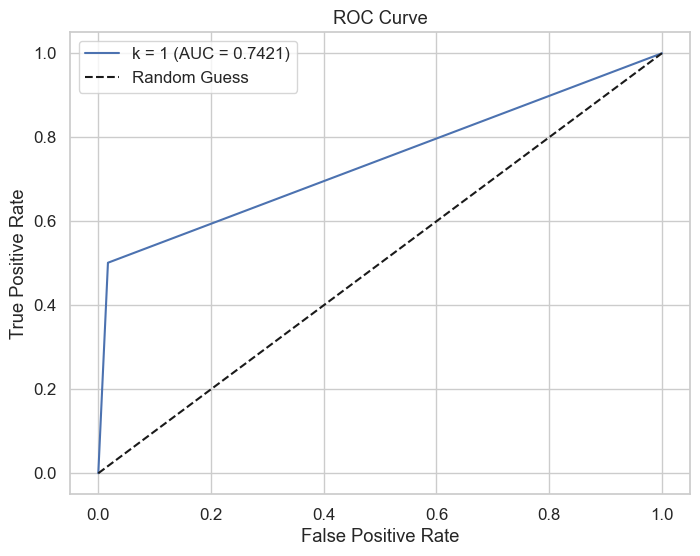

k = 1 → Accuracy: 0.9660
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     91181
           1       0.52      0.50      0.51      3306

    accuracy                           0.97     94487
   macro avg       0.75      0.74      0.75     94487
weighted avg       0.97      0.97      0.97     94487

Confusion Matrix:
[[89621  1560]
 [ 1649  1657]]
--------------------------------------------------
Evaluating k = 3...
AUC: 0.7960


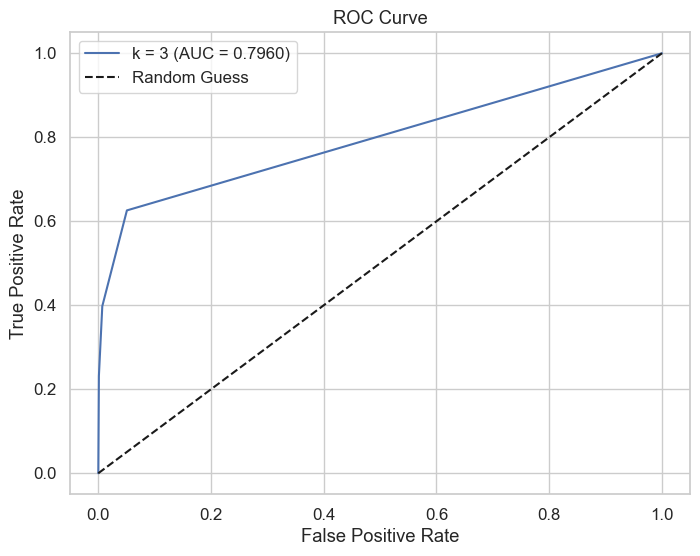

k = 3 → Accuracy: 0.9721
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     91181
           1       0.67      0.40      0.50      3306

    accuracy                           0.97     94487
   macro avg       0.82      0.70      0.74     94487
weighted avg       0.97      0.97      0.97     94487

Confusion Matrix:
[[90536   645]
 [ 1991  1315]]
--------------------------------------------------
Evaluating k = 5...
AUC: 0.8134


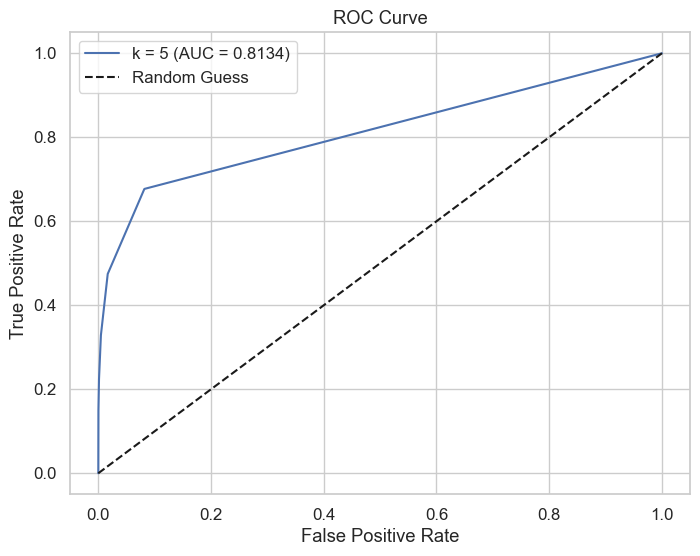

k = 5 → Accuracy: 0.9720
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     91181
           1       0.72      0.33      0.45      3306

    accuracy                           0.97     94487
   macro avg       0.85      0.66      0.72     94487
weighted avg       0.97      0.97      0.97     94487

Confusion Matrix:
[[90759   422]
 [ 2219  1087]]
--------------------------------------------------


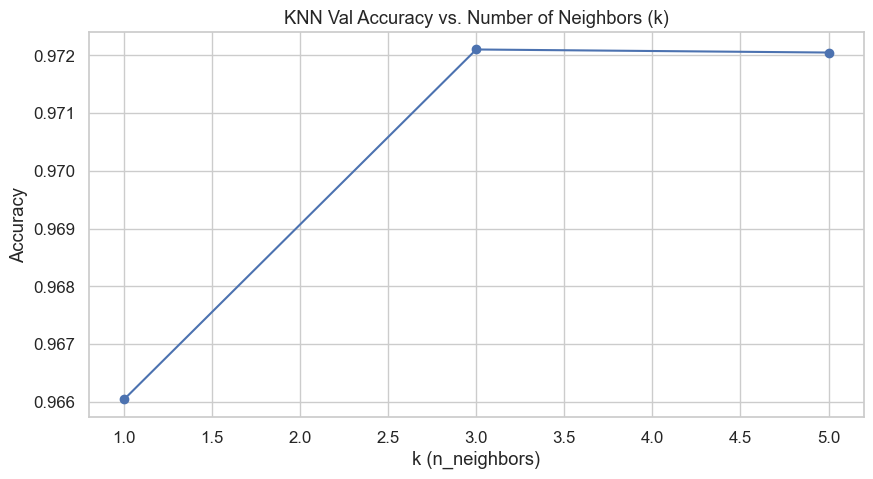

[0.9660376559738376, 0.972101982283277, 0.972049064950734]

In [ ]:
# Evaluate KNN with different k values
k_range = range(1, 11, 2)
evaluate_knn(X_train, y_train, X_val, y_val, k_range)

In [34]:
knn = KNeighborsClassifier(n_neighbors=5)

In [35]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [36]:
y_pred = knn.predict(X_test)

In [37]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9645917296034138
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113975
           1       0.47      0.08      0.14      4133

    accuracy                           0.96    118108
   macro avg       0.72      0.54      0.56    118108
weighted avg       0.95      0.96      0.95    118108

